# Hyperparameters Fine Tuning

Inspired from : 

https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837

### ==== Import libs ====

In [1]:
# ---- utils libs ----
import numpy as np
import pandas as pd
import datetime
from typing import Optional

# ---- Data Viz libs ---- 
import hiplot as hip

# ---- ML libs ----
from sklearn.preprocessing import StandardScaler

# ---- Deep Learning libs ----
from tensorflow import keras
from tensorflow.keras import layers

# ---- Import Hyperparamters Optimization framework ----
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(0,'../src')

# --- Import functions from utils.py ---
from utils import load_dataset, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters, read_pickle_dataset

# --- Import functions from visualize.py ---
sys.path.insert(0,'../src/visualization')
from visualize import visualize_load_curve_dataset

# --- Import functions from train_model.py ---
sys.path.insert(0,'../src/models/')
from train_model import train

# --- Import functions from eval_model.py ---
sys.path.insert(0,'../src/models/')
from eval_model import evaluate

# --- Import functions from predict_model.py ---
sys.path.insert(0,'../src/models/')
from predict_model import X_train_predict, X_test_predict, compute_threshold, compute_test_mae_loss, detect_anomaly_sequence, get_anomaly_df, get_df_predict

# --- Import functions from postprocessing.py ---
sys.path.insert(0,'..')
from postprocessing import data_postprocessing

## Load Curve Dataset

In [3]:
# --- Visualize Load Curve Dataset ---
print("LOAD DATASET...\n\n")
df_load_curve = load_dataset("house1_power_blk2_labels.zip")

LOAD DATASET...




In [4]:
df_load_curve

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.000000
2016-03-06 00:00:01,474.0,0,0.000000
2016-03-06 00:00:02,476.0,0,0.000000
2016-03-06 00:00:03,476.0,0,0.000000
2016-03-06 00:00:04,475.0,0,0.000000
...,...,...,...
2016-05-07 22:59:55,604.0,0,22.983333
2016-05-07 22:59:56,602.0,0,22.983333
2016-05-07 22:59:57,602.0,0,22.983333


## Preprocessing

####  1/ Load the dataset and resample timeseries
####  2/ Split a dataframe into train set and test set according to the split rate
####  3/ Standardize Data
####  4/ Construction of the dataset according to peak and off-peak hours or according to activity labels
####  5/ Creation of sequences of length T and according to the overlapping period

Return preprocessed ``3D-array`` ``[samples, SEQUENCE_LENGTH, features]`` (i.e sequences from the timeseries) , as required for **LSTM** network. We want our network to have memory of **10 days**, so we set ``SEQUENCE_LENGTH=10``.

In [54]:
def data_preprocessing(df_load_curve
                  ,timeframes: list
                  ,sequence_length: int
                  ,overlap_period: int
                  ,resample_period :Optional[str]=None
                  ,use_labels :Optional[bool]=False
                  ,strategy :Optional[str] = "off_peak_time" 
                  ,split_rate :Optional[float]=0.2
                  ,split_method=None) -> np.array:
    """
    1/ Loads the dataset and resample timeseries
    2/ Split a dataframe into train set and test set according to the split rate
    3/ Standardize Data
    4/ Construction of the dataset according to peak and off-peak hours 
    or according to activity labels
    5/ Creation of sequences of length T and according to the overlapping period
    
    Args:
        - df_load_curve: Load curve in a dataframe format
        - resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
        - timeframes: list of tuples indicating the periods of the day ex: timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))
        - use_labels: (False by default) use the activities labels
        - sequence_length: length of the sequence
        - overlap_period: overlap the sequences of timeseries
        - device_approach: the aggregated load curve of the devices which, when in operation, do not allow us to predict an activity 
        - split_rate: Rate of the test set size
        - device_strategy: use inactive devices base load curve
    Returns: 
        - list of prepocessed 3D-array [samples, sequence_length, features] (i.e sequences from the timeseries) 
    """
    
    # Diplay preprocessing parameters
    print("\n---- Post Processing Parameters ----")
    print("TIMEFRAMES = ", timeframes)
    print("SEQUENCE_LENGTH = ", sequence_length)
    print("RESAMPLE_PERIOD = ", resample_period)
    print("OVERLAP_PERIOD = ", overlap_period)
    print("STRATEGY = ", strategy)
        
    # load dataset with labels and resampled timeseries
    print("")
    print("")
    print("#### Resampling Data... ####")
    print("")
    #df_resampled = load_dataset("house1_power_blk2_labels.zip", resample_period)
    df_resampled = df_load_curve.resample(resample_period).nearest()
    df_resampled['hour'] = df_resampled.index.hour + df_resampled.index.minute / 60 #+ dataset.index.seconde / 3600
    df_resampled
    
    print("#### Creating Train and Test set... ####")
    print("")
    print("")
    # split dataframe into train set and test set
    train_df, test_df, mask_test = train_test_split_dataset(df_resampled, method=split_method, split_rate=split_rate)
    
    # Standardize Data
    print("#### Rescaling Data... ####")
    print("")
    print("")
    scaler = StandardScaler()
    scaler_train = scaler.fit(train_df.loc[:, ['mains']])
    
    train_df.loc[:, 'mains'] = scaler_train.transform(train_df.loc[:, ['mains']])
    test_df.loc[:, 'mains'] = scaler_train.transform(test_df.loc[:, ['mains']])
        
    # ---- TEST SEQUENCES ----
    print("#### Creating Test Sequence... ####")
    print("")
    print("")
    if split_method=="random_days":
        list_df_test = []
        mask = ((mask_test) != (np.roll(mask_test, 1)))[mask_test]
        a = np.where(mask)[0]
        if 0 in a and len(a>1):
            a = a[1:]
        for df in np.split(test_df, a):
            list_df_test.append(df)
        # init 3D-array [samples, sequence_length, features]
        first_df_test = list_df_test[0]
        X_sequences_test, y_sequences_test = create_sequence(first_df_test, sequence_length, overlap_period)
        list_df_test.pop(0) # delete the first element of the list of train dataframes

        # Creation of sequences of length T and according to the overlapping period
        for df_test_ in list_df_test:
            next_X_sequences_test, next_y_sequences_test = create_sequence(df_test_, sequence_length, overlap_period)
            X_sequences_test = np.append(X_sequences_test, next_X_sequences_test, axis = 0)
            y_sequences_test = np.append(y_sequences_test, next_y_sequences_test, axis = 0)
    else:
        X_sequences_test, y_sequences_test = create_sequence(test_df, sequence_length, overlap_period)
    
    if strategy == "off_peak_time":
        print("Strategy chosen : ", strategy)
        print("")
        print("#### Creating Train Sequence... ####")
        print("")
        print("")
        # --- TRAIN SEQUENCES ----
        # Construction of the dataset according to peak and off-peak hours 
        if split_method=="random_days":
            list_df_train = []
            mask = ((~mask_test) != (np.roll(~mask_test, 1)))[~mask_test]
            for df in np.split(train_df, np.where(mask)[0]):
                list_df_train.extend(segmentDf(df, timeframes = timeframes))
        else:
            list_df_train = segmentDf(train_df, timeframes = timeframes)

        # init 3D-array [samples, sequence_length, features]
        first_df_train = list_df_train[0]
        print(first_df_train.shape)
        list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
        list_df_train.pop(0) # delete the first element of the list of train dataframes
        
        print(list_X_sequence_train.shape)
        
        # Creation of sequences of length T and according to the overlapping period
        for df_train_ in list_df_train:
            X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
            
            print(X_sequences_train.shape)
            
            list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
            list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
        print("---- X_train sequence shape ----")
        print(list_X_sequence_train.shape)

        print("\n---- y_train sequence shape ----")
        print(list_y_sequence_train.shape)

        print("\n\n---- X_test sequence shape ----")
        print(X_sequences_test.shape)

        print("\n---- y_test sequence shape ----")
        print(y_sequences_test.shape)
        
        return train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

In [55]:
# %timeit
# def apply_preprocessing(trial):
    
#     # --- Define the range of global variables ---
#     trial_time_step_minutes = trial.suggest_int("trial_time_step_minutes", 1, 1) 
#     trial_time_step_seconds = trial.suggest_int("trial_time_step_seconds", 30, 30) 
    
#     trial_duration_time = trial.suggest_int("trial_duration_time", 60, 60) 
    
#     trial_overlap_percent = trial.suggest_float("trial_overlap_percent", 0.8, 0.8)
    
#     trial_timeframe_start_hours =  trial.suggest_int("trial_timeframe_start_hours", 0, 0)
#     trial_timeframe_start_minutes =  trial.suggest_int("trial_timeframe_start_minutes", 0, 0)
#     trial_timeframe_end_hours =  trial.suggest_int("trial_timeframe_end_hours", 3, 3)
#     trial_timeframe_end_minutes =  trial.suggest_int("trial_timeframe_end_minutes", 0, 0)
    
    
#     # --- Define global variables ---
#     TIME_STEP = datetime.timedelta(minutes=trial_time_step_minutes, seconds=trial_time_step_seconds) # duration of a step in the resample dataset, originally 1 second
#     DURATION_TIME = datetime.timedelta(minutes=trial_duration_time) # duration of a sequence
#     OVERLAP_PERIOD_PERCENT = trial_overlap_percent # 0.5 <=> 50% overlapping
#     TIMEFRAMES = [(datetime.time(trial_timeframe_start_hours,trial_timeframe_start_minutes,0), 
#                    datetime.time(trial_timeframe_end_hours,trial_timeframe_end_minutes,0))] # timeframes we consider as unactive
    
#     # Don't change
#     STRATEGY = "off_peak_time" # device, off_peak_time, label 
#     METHOD = "method_prediction_1" # method to choose for aggregating sequences
#     SPLIT_METHOD = "random_days" # method for train test split, None or "random_days"

    
#     print("CONVERTING GLOBAL USER PARAMETERS...\n")
#     SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)
#     print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t\t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

#     # --- Pre Processing ---
#     print("STARTING PREPROCESSING...\n")
#     train_df, test_df, X_train, y_train, X_test, y_test = data_preprocessing(df_load_curve
#                                                                                  ,timeframes = TIMEFRAMES
#                                                                                  ,sequence_length = SEQUENCE_LENGTH
#                                                                                  ,overlap_period = OVERLAP_PERIOD
#                                                                                  ,resample_period = TIME_STEP
#                                                                                  ,strategy = STRATEGY
#                                                                                  ,split_method=SPLIT_METHOD)
    
#     return METHOD, SEQUENCE_LENGTH, train_df, test_df, X_train, y_train, X_test, y_test

In [64]:
range_timeframe_start_end = list()
for idx, i in enumerate([22, 23, 0, 1, 2]):
    for idx_, j in enumerate([22, 23, 0, 1, 2]):
        if idx_ > idx:
            tulple = (i,j)
            range_timeframe_start_end.append(tulple)
        
range_timeframe_start_end

[(22, 23),
 (22, 0),
 (22, 1),
 (22, 2),
 (23, 0),
 (23, 1),
 (23, 2),
 (0, 1),
 (0, 2),
 (1, 2)]

In [65]:
%timeit
def apply_preprocessing(trial):
    
    # --- Define the range of global variables ---
    trial_time_step_minutes = trial.suggest_categorical("trial_time_step_minutes", [0, 1, 2, 3, 4]) 
    trial_time_step_seconds = trial.suggest_categorical("trial_time_step_seconds", [0, 5, 10, 20, 30, 40, 50, 60]) 
    
    trial_duration_time = trial.suggest_categorical("trial_duration_time", [5, 10, 20, 30, 40, 50, 60]) 
    
    trial_overlap_percent = trial.suggest_categorical("trial_overlap_percent", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    
    range_timeframe_start_end = list()
    for idx, i in enumerate([22, 23, 0, 1, 2]):
        for idx_, j in enumerate([22, 23, 0, 1, 2]):
            if idx_ > idx:
                tulple = (i,j)
                range_timeframe_start_end.append(tulple)

    range_timeframe_start_end
    
    trial_timeframe_start_end_hours =  trial.suggest_categorical("trial_timeframe_start_hours", range_timeframe_start_end)
    trial_timeframe_start_minutes =  trial.suggest_categorical("trial_timeframe_start_minutes", [0, 30])
    trial_timeframe_end_minutes =  trial.suggest_categorical("trial_timeframe_end_minutes", [0, 30])
    
    
    
    # --- Define global variables ---
    TIME_STEP = datetime.timedelta(minutes=trial_time_step_minutes, seconds=trial_time_step_seconds) # duration of a step in the resample dataset, originally 1 second
    DURATION_TIME = datetime.timedelta(minutes=trial_duration_time) # duration of a sequence
    OVERLAP_PERIOD_PERCENT = trial_overlap_percent # 0.5 <=> 50% overlapping
    TIMEFRAMES = [(datetime.time(trial_timeframe_start_end_hours[0],trial_timeframe_start_minutes,0), 
                   datetime.time(trial_timeframe_start_end_hours[1],trial_timeframe_end_minutes,0))] # timeframes we consider as unactive
    
    # Don't change
    STRATEGY = "off_peak_time" # device, off_peak_time, label 
    METHOD = "method_prediction_1" # method to choose for aggregating sequences
    SPLIT_METHOD = "random_days" # method for train test split, None or "random_days"

    
    print("CONVERTING GLOBAL USER PARAMETERS...\n")
    SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)
    print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t\t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

    # --- Pre Processing ---
    print("STARTING PREPROCESSING...\n")
    train_df, test_df, X_train, y_train, X_test, y_test = data_preprocessing(df_load_curve
                                                                             ,timeframes = TIMEFRAMES
                                                                             ,sequence_length = SEQUENCE_LENGTH
                                                                             ,overlap_period = OVERLAP_PERIOD
                                                                             ,resample_period = TIME_STEP
                                                                             ,strategy = STRATEGY
                                                                             ,split_method=SPLIT_METHOD)
    
    return METHOD, SEQUENCE_LENGTH, train_df, test_df, X_train, y_train, X_test, y_test

## Build a custom architecture of an auto-encoder convolutional model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (``batch_size``, ``sequence_length``, ``num_features``) and return output of the same shape.

In [66]:
def build_custom_model(trial, X_train):
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    
    model.add(layers.Conv1D(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ))
    model.add(layers.Conv1D(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ))
            
    model.add(layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ))
            
    model.add(layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ))
            
    model.add(layers.Conv1DTranspose(
        filters=1, kernel_size=4, padding="same"
    ))
        
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
            
    return model 

## Build custom metric

Pour calculer l'aire sous courbe on a appliquer la **somme de Riemann**

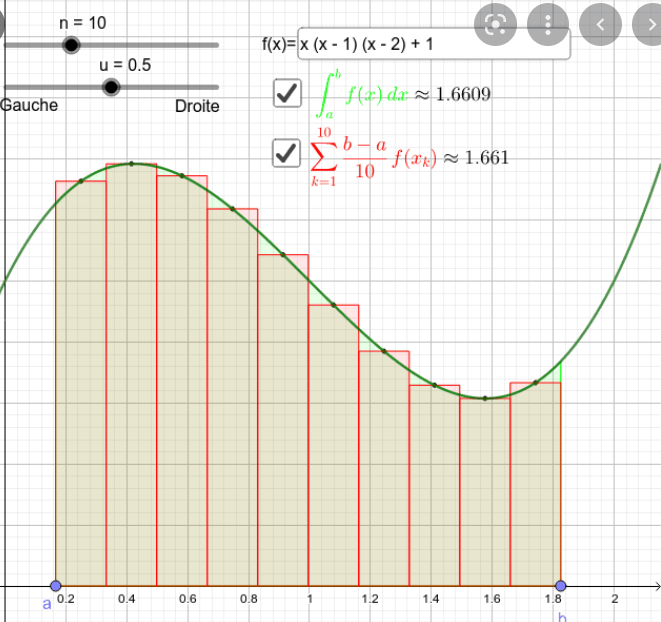

In [67]:
def AreaUnderCurve(curve):
    area_curve = curve[:-1] + curve[1:]
    quotients = [ area_curve / 2 for area_curve in area_curve]
    return sum(quotients) / (len(curve)-1)


def singleMetric(MAP, MAR, IoU_thresholds, tau=0.05, alpha=1, alpha_AUC=1, beta=1, mode = 3):
    """
    Args : 
        - mode :
            - 1 : AUC_MAP + alpha_AUC * AUC_MAR
            - 2 : MAP(tau) + alpha * MAP(tau)
            - 3 : 1 + beta * 2
    Returns : a single metric for the MAP and MAR curves
    """
    AUC_MAP =  AreaUnderCurve(MAP)
    AUC_MAR =  AreaUnderCurve(MAR)
    res1 = (AUC_MAP + alpha_AUC*AUC_MAR)/(1+alpha_AUC)
    
    idx = np.abs(IoU_thresholds - tau).argmin()
    res2 = (MAP[idx] + alpha * MAR[idx])/(1+alpha)
    
    if mode == 1:
        return res1
    elif mode == 2:
        return res2
    elif mode ==3 :
        return (res1 + res2)/(1+beta)
    else : 
        raise ValueError("Invalid mode argument for singleMetric function")

In [68]:
def custom_metric(df_load_curve, METHOD):
    
    # --- Load data prediction post processing --- #
    print("\n\nLOADING DATA PREDICTION POSTPROCESSING...")
    data_prediction_post_process = read_pickle_dataset("data_prediction.pkl")

    y_pred = data_prediction_post_process[["Timestamp", METHOD]]
    y_true = df_load_curve[(df_load_curve.index>=y_pred["Timestamp"].min())&(df_load_curve.index<=y_pred["Timestamp"].max())].reset_index()[["datetime", "activity"]]
    y_true = y_true[y_true["datetime"].isin(y_pred["Timestamp"])] #restriction de y_true aux timestamps contenus dans y_pred

    IoU_thresholds, MAP, MAR = evaluate(y_pred, y_true, display_plots=False)
    print(MAP)
    # TO COMPLETE because to get MAP, MAR value
    
    # A example of scoring formula to MAXIMIZE
    performance = singleMetric(MAP, MAR, IoU_thresholds)

    return performance

### Define objective function

In [69]:
def objective(trial):
 
    # --- Pre Processing ---
    print("STARTING PREPROCESSING...\n")
    METHOD, SEQUENCE_LENGTH, train_df, test_df, X_train, y_train, X_test, y_test = apply_preprocessing(trial)

    # --- Build Model ---
    print("\n\nBUILDING MODEL...")
    model = build_custom_model(trial, X_train)
    
    # --- Train Model ---
    print("\n\nTRAININ MODEL...")
    history = train(model, X_train)
    
    # --- Prediction Model on X_train ---
    print("\n\nMAKING PREDICTION FOR X_train...")
    X_train_pred = X_train_predict(model, X_train)

    # --- Compute Threshold ---
    print("\n\nCOMPUTING THRESHOLD...")
    threshold = compute_threshold(X_train_pred, X_train)
    
    # --- Prediction Model on X_test ---
    print("\n\nMAKING PREDICTION FOR X_test...")
    X_test_pred = X_test_predict(model, X_test)

    # --- Compute test mae loss
    print("\n\nCOMPUTING TEST MAE LOSS...")
    test_mae_loss = compute_test_mae_loss(X_test_pred, X_test)
    
    # --- Detect anomalies ---
    print("\n\nDETECTING ANOMALIES...")
    sequences_anomalies_idx, data_anomalies_idx = detect_anomaly_sequence(test_mae_loss, threshold, SEQUENCE_LENGTH, y_test)

    # --- Build anomaly dataframe ---
    print("\n\nBUILDING ANOMALY DATAFRAME...")
    df_anomalies = get_anomaly_df(data_anomalies_idx, test_df)
    print(df_anomalies)
    
    # --- Build prediction dataframe ---
    print("\n\nBUILDING PREDICTION DATAFRAME...")
    df_predict = get_df_predict(test_df, df_anomalies)
    
    # --- Post Processing --- 
    print("\n\nPOSTPROCESSING...")
    data_postprocessing(y_test, SEQUENCE_LENGTH, sequences_anomalies_idx, True)

    # --- Model Evaluation --- 
    score = custom_metric(df_load_curve, METHOD)
    
    return score

## Fine-tune hyperpamarameters with ``optuna``

In [70]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 5)

[I 2022-06-28 21:34:38,758] A new study created in memory with name: no-name-68d0c242-1694-496c-85ae-a087d21eb927


STARTING PREPROCESSING...

CONVERTING GLOBAL USER PARAMETERS...

		Valeur choisie 	 Equivalent sequence
Timestep : 	 0:04:05
Duration :	 0:30:00 	 -->  8 
Overlap :	 0.7 		 -->  5
STARTING PREPROCESSING...


---- Post Processing Parameters ----
TIMEFRAMES =  [(datetime.time(22, 0), datetime.time(1, 30))]
SEQUENCE_LENGTH =  8
RESAMPLE_PERIOD =  0:04:05
OVERLAP_PERIOD =  5
STRATEGY =  off_peak_time


#### Resampling Data... ####

#### Creating Train and Test set... ####


#### Rescaling Data... ####


#### Creating Test Sequence... ####


Strategy chosen :  off_peak_time

#### Creating Train Sequence... ####


(23, 7)
(5, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15, 8, 1)
(15

[I 2022-06-28 21:34:46,731] Trial 0 finished with value: 0.3373168498168499 and parameters: {'trial_time_step_minutes': 4, 'trial_time_step_seconds': 5, 'trial_duration_time': 30, 'trial_overlap_percent': 0.7, 'trial_timeframe_start_hours': (22, 1), 'trial_timeframe_start_minutes': 0, 'trial_timeframe_end_minutes': 30}. Best is trial 0 with value: 0.3373168498168499.


[0.7692307692307693, 0.7307692307692307, 0.7307692307692307, 0.7307692307692307, 0.6538461538461539, 0.6538461538461539, 0.6153846153846154, 0.6153846153846154, 0.5384615384615384, 0.5, 0.5, 0.46153846153846156, 0.46153846153846156, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.4230769230769231, 0.38461538461538464, 0.38461538461538464, 0.38461538461538464, 0.38461538461538464, 0.38461538461538464, 0.38461538461538464, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077, 0.19230769230769232, 0.19230769230769232, 0.19230769230769232, 0.19230769230769232, 0.19230769230769232, 0.15384615384615385, 0.15384615384615385, 0.153846153846

[W 2022-06-28 21:34:50,353] Trial 1 failed because of the following error: ValueError("in user code:\n\n    C:\\Users\\asus\\anaconda3\\lib\\site-packages\\tensorflow\\python\\keras\\engine\\training.py:806 train_function  *\n        return step_function(self, iterator)\n    C:\\Users\\asus\\anaconda3\\lib\\site-packages\\tensorflow\\python\\keras\\engine\\training.py:796 step_function  **\n        outputs = model.distribute_strategy.run(run_step, args=(data,))\n    C:\\Users\\asus\\anaconda3\\lib\\site-packages\\tensorflow\\python\\distribute\\distribute_lib.py:1211 run\n        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)\n    C:\\Users\\asus\\anaconda3\\lib\\site-packages\\tensorflow\\python\\distribute\\distribute_lib.py:2585 call_for_each_replica\n        return self._call_for_each_replica(fn, args, kwargs)\n    C:\\Users\\asus\\anaconda3\\lib\\site-packages\\tensorflow\\python\\distribute\\distribute_lib.py:2945 _call_for_each_replica\n        return 



TRAININ MODEL...
Epoch 1/50


ValueError: in user code:

    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10397 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 32 and 30 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_5/conv1d_transpose_14/BiasAdd, IteratorGetNext:1)' with input shapes: [?,32,1], [?,30,1].


## Show result into a dataframe

In [ ]:
#show optuna results

result_df = study.trials_dataframe()
result_df

## Show best trial

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

## Visualization of Tuning Process

### Visualize the optimization history

In [ ]:
optuna.visualization.plot_optimization_history(study)

### Visualize the result of each trials

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

## Visualization of the impact of hyperparameters on the evaluation metric with ``HiPlot``

In [ ]:
df_hiplot = result_df[["value", 
                       "params_trial_duration_time", 
                       "params_trial_overlap_percent", 
                       "params_trial_time_step_minutes", 
                       "params_trial_time_step_seconds", 
                       "params_trial_timeframe_end_hours", 
                       "params_trial_timeframe_end_minutes", 
                       "params_trial_timeframe_start_hours", 
                       "params_trial_timeframe_start_minutes"]]


result_hiplot = hip.Experiment.from_dataframe(df_hiplot)
result_hiplot.display()

In [ ]:
df_hiplot